In [1]:
#Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")

import tensorflow_probability as tfp
import tensorflow as tf

from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
#Load the data

df = pd.read_csv("AirPassengers.csv",
                 index_col = "Month",
                 parse_dates = True)

df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


#### Data Transformation

In [3]:
#Rename variables

df.rename(columns = {"#Passengers": "AirPassengers"},
          inplace = True)

In [5]:
#Change index frequency

df = df.asfreq("MS")

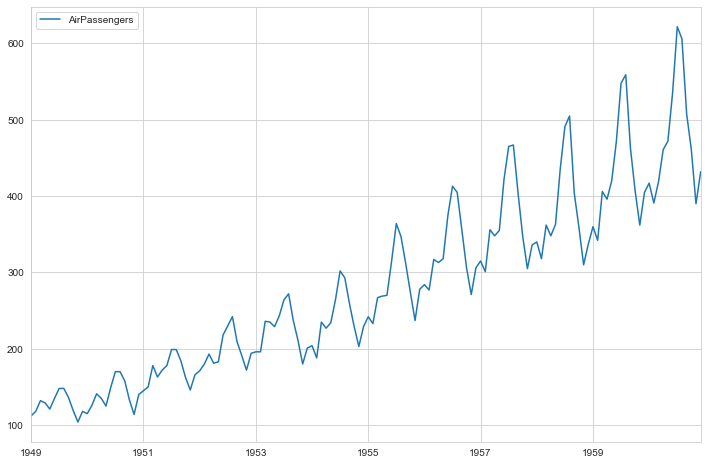

In [9]:
#Visualization

df["AirPassengers"].plot(figsize = (12,8),
                         legend = True)

plt.xlabel(None);

#### Training and Test Sets

In [10]:
test_months = 12

training_set = df.iloc[:-test_months, :]

test_set = df.iloc[-test_months:, :]

#### Seasonality

In [11]:
#Isolating the dependent variable

y = training_set["AirPassengers"].astype(float)

In [20]:
#Number of days per month list

num_days_per_month = np.array([[31,28,31,30,31,30,31,31,30,31,30,31], #1949
                               [31,28,31,30,31,30,31,31,30,31,30,31], #1950
                               [31,28,31,30,31,30,31,31,30,31,30,31], #1951
                               [31,29,31,30,31,30,31,31,30,31,30,31], #1952
                               [31,28,31,30,31,30,31,31,30,31,30,31], #1953
                               [31,28,31,30,31,30,31,31,30,31,30,31], #1954
                               [31,28,31,30,31,30,31,31,30,31,30,31], #1955
                               [31,29,31,30,31,30,31,31,30,31,30,31], #1956
                               [31,28,31,30,31,30,31,31,30,31,30,31], #1957
                               [31,28,31,30,31,30,31,31,30,31,30,31], #1958
                               [31,28,31,30,31,30,31,31,30,31,30,31], #1959
                               [31,29,31,30,31,30,31,31,30,31,30,31]])#1960

In [21]:
#Monthly seasonality

monthly_effect = tfp.sts.Seasonal(num_seasons = 12,
                                  num_steps_per_season = num_days_per_month,
                                  observed_time_series = y,
                                  name = "monthly_efect")

#### Autoregressive and Trend components

In [22]:
#Autoregressive

autoregressive = tfp.sts.Autoregressive(order = 1,
                                        observed_time_series = y,
                                        name = "autoregressive")

In [23]:
#Trend

trend = tfp.sts.LocalLinearTrend(observed_time_series = y,
                                 name = "trend")

#### Tensorflow Structural Time Series

In [24]:
#Forecasting model

model = tfp.sts.Sum([monthly_effect,
                     autoregressive,
                     trend],
                    observed_time_series = y)

In [25]:
#Fit with Hamiltonian Monte Carlo

samples, kernel_results = tfp.sts.fit_with_hmc(model = model,
                                               observed_time_series = y,
                                               num_results = 100,
                                               num_warmup_steps = 50,
                                               num_leapfrog_steps = 15,
                                               num_variational_steps = 150,
                                               seed = 45)

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


C:\Users\franc\anaconda3\lib\site-packages\tensorflow_probability\python\mcmc\sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


In [26]:
#Forecast

forecast = tfp.sts.forecast(model = model,
                            observed_time_series = y,
                            parameter_samples = samples,
                            num_steps_forecast = test_months)

In [33]:
#Predictions

tfp_predictions = pd.Series(forecast.mean()[:,0], name = "TFP")

tfp_predictions.index = test_set.index

tfp_predictions

Month
1960-01-01    406.231107
1960-02-01    407.612525
1960-03-01    408.955019
1960-04-01    410.301144
1960-05-01    411.633521
1960-06-01    412.963130
1960-07-01    414.286508
1960-08-01    415.606793
1960-09-01    416.923542
1960-10-01    418.237826
1960-11-01    419.549791
1960-12-01    420.859904
Freq: MS, Name: TFP, dtype: float64

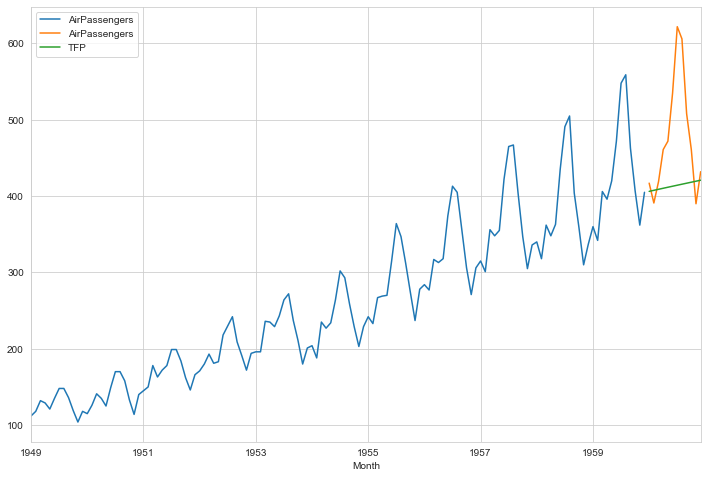

In [39]:
#Visualization

training_set["AirPassengers"].plot(figsize = (12,8),
                                   legend = True)

test_set["AirPassengers"].plot(legend = True)

tfp_predictions.plot(legend = True);

#### Model Assessment

In [38]:
#MAE and RSME

print("MAE:",round(mean_absolute_error(test_set["AirPassengers"], tfp_predictions),0))

print("MRSE:",round(np.sqrt(mean_squared_error(test_set["AirPassengers"], tfp_predictions)),0))

MAE: 70.0
MRSE: 97.0


In [40]:
#MAPE 

def MAPE(y_true, y_preds):
    y_true, y_pred = np.array(y_true), np.array(y_preds)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

MAPE(test_set["AirPassengers"], tfp_predictions)

13.166562616186445

#### Export Predictions

In [41]:
tfp_predictions.to_csv("TFP_12Months_Forecast.csv", index = True)